# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 20.09.2022

Мягкий дедлайн: 23:59MSK 04.10.2022

Жесткий дедлайн: 23:59MSK 10.10.2022

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [45]:
%reset
import random

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from IPython.display import clear_output
from torchvision import transforms

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# %conda install wget

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [46]:
df = pd.read_csv("data/YearPredictionMSD.txt", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [47]:
df = df.astype(np.float32)

In [48]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]
y_test.shape

(51630,)

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [49]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
scaler_y = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

mean_y = y_train.mean(0)
std_y = y_train.std(0)

y_train_sc = (y_train - mean_y) / std_y
y_test_sc = (y_test - mean_y) / std_y

ridge = Ridge()
ridge.fit(X_train_sc, y_train_sc)
print(f'RMSE - {mean_squared_error(y_test_sc, ridge.predict(X_test_sc)) ** 0.5}')

RMSE - 0.8693211400168139


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [50]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
class Model(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.fc1 = nn.Linear(90, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.do = nn.Dropout(0.3)
        self.act = activation()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.act2 = activation()
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.act3 = activation()
        self.fc4 = nn.Linear(32, 1)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.do(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.fc4(x)
        return x

In [114]:
train_set = [(torch.from_numpy(data), torch.from_numpy(ans)) for data, ans in zip(X_train_sc, y_train_sc.reshape(-1, 1))]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

test_set = [(torch.from_numpy(data), torch.from_numpy(ans)) for data, ans in zip(X_test_sc, y_test_sc.reshape(-1, 1))]
test_loader = torch.utils.data.DataLoader(test_set, batch_size=51630, shuffle=False)

model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
model.cuda()

Model(
  (fc1): Linear(in_features=90, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do): Dropout(p=0.3, inplace=False)
  (act): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

In [116]:
def plot_rmse(x, y, xval, yval):
    clear_output()
    plt.plot(x, y, color='green', label='train')
    plt.plot(xval, yval, color='orange', label='test')
    plt.legend()
    plt.title('RMSE')
    plt.xlabel("Эпохи")
    plt.ylabel("Качество")
    plt.grid()
    plt.show()

In [117]:
def train(model, optimizer, criterion, train_loader, test_loader, n_epochs=10):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    loss_train = []
    loss_test = []
    for epoch in range(n_epochs):
        
        loss_train_epoch = []
        loss_test_epoch = []
        mean_epoch = []
        
        model.train()
        for imgs, labels in tqdm(train_loader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            y_pred = model(imgs)
            pred = y_pred.clone().cpu()
            pred_year = pred.detach().numpy() * std_y + mean_y
            y_true = labels.clone().cpu()
            true_year = y_true.detach().numpy() * std_y + mean_y
            rmse = (((pred_year - true_year) ** 2).sum() / len(pred_year)) ** 0.5
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train_epoch.append(rmse)
            
        loss_train.append(torch.tensor(loss_train_epoch).mean().item())
        print(f'RMSE on train - {loss_train[-1]}')
        
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(test_loader, desc=f"Validating, epoch {epoch}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                y_pred = model(imgs)
                pred = y_pred.clone().cpu()
                pred_year = pred.detach().numpy() * std_y + mean_y
                y_true = labels.clone().cpu()
                true_year = y_true.detach().numpy() * std_y + mean_y
                rmse = (((pred_year - true_year) ** 2).sum() / len(pred_year)) ** 0.5
                loss = criterion(y_pred, labels)
                loss_test_epoch.append(rmse)
                
            loss_test.append(torch.tensor(loss_test_epoch).mean().item())
            plot_rmse(np.arange(epoch + 1), loss_train, np.arange(epoch + 1), loss_test)
            print(f'RMSE on test - {loss_test[-1]}')
                
                
                
            

def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    with torch.no_grad():
        imgs, labels = next(iter(test_loader))
        imgs, labels = imgs.to(device), labels.to(device)
        predicts = model(imgs)  * std_y + mean_y
        true = labels * std_y + mean_y
        
        print(f"RMSE = {(((predicts - true) ** 2).sum() / predicts.size()[0]) ** 0.5}")
        
    return predicts

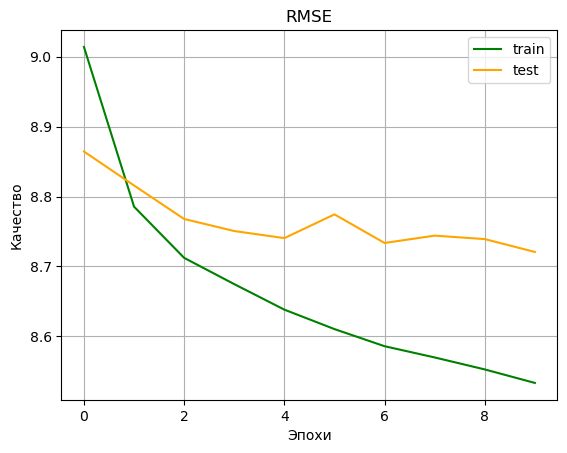

RMSE on test - 8.720768388068024


In [118]:
train(model, optimizer, criterion, train_loader, test_loader, n_epochs=10)

In [119]:
(((torch.from_numpy(y_test).reshape(-1, 1).cuda() - test(model, criterion, test_loader)) ** 2).sum() / y_test.shape[-1]) ** 0.5

RMSE = 8.720768928527832


tensor(8.7208, device='cuda:0')

In [120]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

RMSE = 8.720768928527832


## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [ ]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ